# Objetivo
Georeferenciar las estaciones de biblicletas

In [1]:
#funciones y clases particulares al caso de estudio
from localpacks.data import get_data, get_data_others

#para trabajar con nuestro dataframe
import pandas as pd

#graficos
import matplotlib.pyplot as plt

#geodata
import geopandas as gpd
from shapely.geometry import Point,LineString
#draw map streets
import osmnx as ox
#utilidades para trabajar con datos GPS
from geopy.distance import geodesic

# 1. Dataset Estaciones
Este dataset, contiene las coordenadas GPS de todas las estaciones de bicicletas.

In [2]:
estaciones_raw = get_data_others('estaciones')

In [3]:
estaciones = get_data_others('estaciones', apply_format=True) #cargamos nuestro df y le damos formato

In [4]:
estaciones.head()

,nro_est,nombre,lat,long
0,1,Facultad de Derecho,-34.583133,-58.392452
1,2,Retiro,-34.592589,-58.374822
2,3,Aduana,-34.611242,-58.368918
3,4,Plaza Roma,-34.601721,-58.368950
4,6,Parque Lezama,-34.628301,-58.369709


# 2. Georeferenciar Estaciones
Lo siguiente es poder asignar cada uno de estos puntos de las estaciones, con el data set que contiene el uso de las estaciones, entonces, lo primero que vamos a verificar es si podemos intersectar las estaciones, entre los distintos dataframes.

In [5]:
#observamos que tenemos un número de estaciones que van del 1 al 200
estaciones['nro_est'].sort_values().values

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

Concluimos que para poder georegerenciar todos los puntos, debemos dejar solo aquellos id comunes.

### 2.1 Usaremos de ejemplo el año 2018
Con los datos del **Data Set Estaciones** georeferenciaremos a las estaciones del df_2018.

**Nota:**este procedimiento es válido para cualquier otro año.

In [6]:
df = get_data(year=2018, apply_format=True)

In [7]:
df.shape

(2272605, 8)

In [8]:
df.head(3)

,usuario_id,origen_nombre,origen_id,destino_nombre,destino_id,usuario_genero,usuario_edad,tiempo_uso(s)
fecha_uso,,,,,,,,
2018-01-01 00:08:05,5453,Uruguay,45,Virrey Cevallos,183,M,45,1193
2018-01-01 00:18:05,673,Posadas,189,Guardia Vieja,110,M,61,1579
2018-01-01 00:20:14,179119,Hospital Rivadavia,50,Padilla,31,F,52,1659


Lo que vamos a hacer es, eliminar todas las estaciones conun **id** mayor a 200, debido a que estas no aparecen en el **Data Set Estaciones**.

In [9]:
print(' origen_id  > 200: {}\n destino_id > 200: {}'.format(df[df['origen_id'] > 200].shape, df[df['destino_id'] > 200].shape))

 origen_id  > 200: (10, 8)
 destino_id > 200: (442, 8)


El número de rows con estaciones que no podemos georeferenciar es pequeño, por lo tanto los eliminaremos.

In [10]:
df.drop(df[df['origen_id'] > 200].index, inplace=True)
df.drop(df[df['destino_id'] > 200].index, inplace=True)

In [11]:
df.shape

(2272090, 8)

### 2.2 GEOREFERENCIA - Experimento con 10.000 rows
En este apartado, el objetivo será agregarle a nuestro data_frame, las **coordenadas GPS** de la `origen_id` y `destino_id` que le corresponden.

In [44]:
df_cut = df[:10000] #trabajaremos con subset por simplicidad en las pruebas

In [45]:
df_cut.head()

,usuario_id,origen_nombre,origen_id,destino_nombre,destino_id,usuario_genero,usuario_edad,tiempo_uso(s)
fecha_uso,,,,,,,,
2018-01-01 00:08:05,5453,Uruguay,45,Virrey Cevallos,183,M,45,1193
2018-01-01 00:18:05,673,Posadas,189,Guardia Vieja,110,M,61,1579
2018-01-01 00:20:14,179119,Hospital Rivadavia,50,Padilla,31,F,52,1659
2018-01-01 00:20:22,400147,Macacha Güemes,111,Acuña de Figueroa,54,M,27,2931
2018-01-01 00:20:31,400156,Macacha Güemes,111,Acuña de Figueroa,54,F,27,2967


In [46]:
values_origen = pd.DataFrame() #creamos dos DF auxiliares, contendran las estaciones georeferenciadas
values_destino = pd.DataFrame()
for row in df_cut[:].iterrows():
    values_origen = values_origen.append(estaciones[estaciones['nro_est'] == row[1]['origen_id']])
    values_destino = values_destino.append(estaciones[estaciones['nro_est'] == row[1]['destino_id']])

**Observación:** una aproximación lineal optimista, indica que el calculo para los 2millones de rows tardaría 1h:20m:0s

### 2.3 Experimento de calulo de distancias

In [47]:
#para poder agregarlas al df, necesitamos ajustar el indice
values_origen.index = df_cut.index
values_destino.index = df_cut.index

In [48]:
#creamos un punto a partir de las coordenadas

#las unimos
values_origen['coord_origen'] = list(zip(values_origen.long, values_origen.lat))
values_destino['coord_destino'] = list(zip(values_destino.long, values_destino.lat))

#llamamos a al metodo
values_origen['coord_origen'] = values_origen['coord_origen'].apply(Point)
values_destino['coord_destino'] = values_destino['coord_destino'].apply(Point)

In [49]:
#eliminamos los valores que no utilizaremos
values_origen.drop(['lat','long','nro_est','nombre'],axis=1,inplace=True)
values_destino.drop(['lat','long','nro_est','nombre'],axis=1,inplace=True)

In [50]:
#agregamos los datos a nuestro DF
df_cut = pd.concat([df_cut,values_origen,values_destino], axis=1)

In [52]:
#ESTE PASO NO ME CONVENCE AUN, LA DISTANCIA NO SE EN QUE UNIDADES ESTA

#df['distancia'] = origen.distance(destino)
#origen = gpd.GeoDataFrame(df_cut, geometry='coord_origen')
#destino = gpd.GeoDataFrame(df_cut, geometry='coord_destino')

In [53]:
df_cut.head(3)

,usuario_id,origen_nombre,origen_id,destino_nombre,destino_id,usuario_genero,usuario_edad,tiempo_uso(s),coord_origen,coord_destino
fecha_uso,,,,,,,,,,
2018-01-01 00:08:05,5453,Uruguay,45,Virrey Cevallos,183,M,45,1193,POINT (-58.3869126629142 -34.6016160280163),POINT (-58.3896919074047 -34.6156376341942)
2018-01-01 00:18:05,673,Posadas,189,Guardia Vieja,110,M,61,1579,POINT (-58.3855860204811 -34.58847469464069),POINT (-58.415459396243 -34.6017606028946)
2018-01-01 00:20:14,179119,Hospital Rivadavia,50,Padilla,31,F,52,1659,POINT (-58.4011477812048 -34.5836773298631),POINT (-58.4397092182403 -34.60316236138861)


# 3. Mapa Generico CABA - EXPERIMENTO

## 3.1 Ploteando un row

In [43]:
p1 = Point(-58.3869126629142, -34.6016160280163)
p2 = Point(-58.3896919074047, -34.6156376341942)
line = LineString([p1,p2])

In [39]:
G = ox.graph_from_place('Capital Federal, Argentina', network_type='drive')
ox.save_graph_shapefile(G, 'openstreetmap_argentina', folder='.')

C:\Users\USUARIO\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [40]:
caba_map = gpd.read_file("openstreetmap_argentina/edges/")

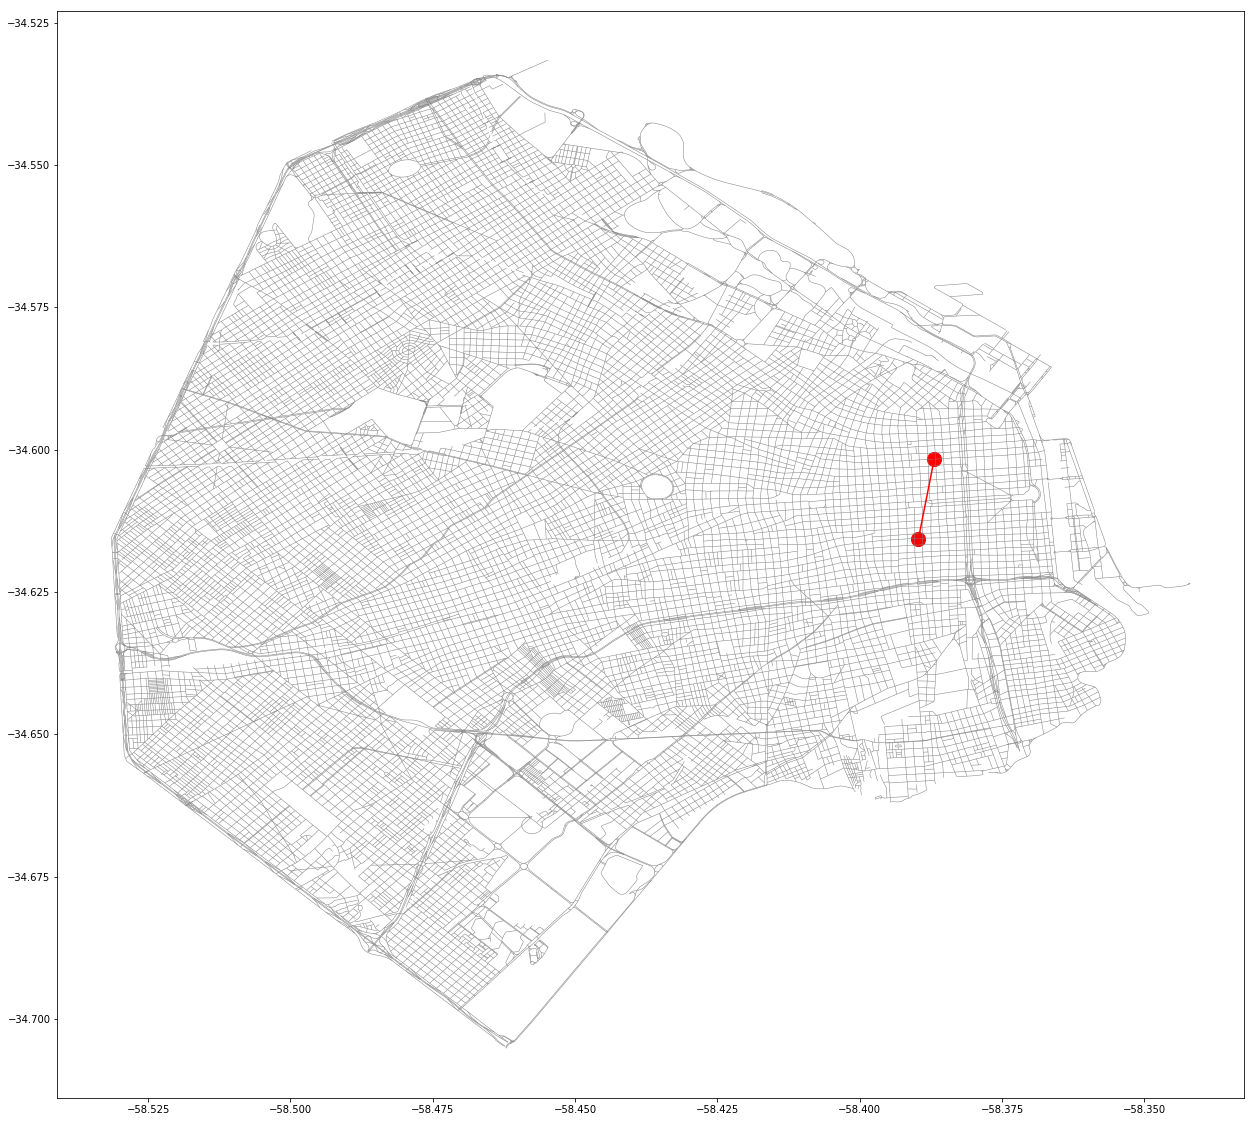

In [54]:
ax = caba_map.plot(linewidth=0.5, color='grey', figsize=(100, 20))
gpd.GeoSeries([p1,p2,line]).plot(ax=ax,markersize=200,color='red');
#ax.set_axis_off()

Funciona para un row.

## 3.2 Ploteando multiples rows

In [94]:
df_cut = df[:1000] #trabajaremos con subset por simplicidad en las pruebas

In [95]:
values_origen = pd.DataFrame() #creamos dos DF auxiliares, contendran las estaciones georeferenciadas
values_destino = pd.DataFrame()
for row in df_cut[:].iterrows():
    values_origen = values_origen.append(estaciones[estaciones['nro_est'] == row[1]['origen_id']])
    values_destino = values_destino.append(estaciones[estaciones['nro_est'] == row[1]['destino_id']])

#para poder agregarlas al df, necesitamos ajustar el indice
values_origen.index = df_cut.index
values_destino.index = df_cut.index

In [96]:
values_destino.head()

,nro_est,nombre,lat,long
fecha_uso,,,,
2018-01-01 00:08:05,183,Virrey Cevallos,-34.615638,-58.389692
2018-01-01 00:18:05,110,Guardia Vieja,-34.601761,-58.415459
2018-01-01 00:20:14,31,Padilla,-34.603162,-58.439709
2018-01-01 00:20:22,54,Acuña de Figueroa,-34.598222,-58.421705
2018-01-01 00:20:31,54,Acuña de Figueroa,-34.598222,-58.421705


In [ ]:
values_origen['lat'].values
values_origen['long'].values

In [98]:
values_origen['coord_origen'] = Point(list(zip(values_origen.long, values_origen.lat)))
values_destino['coord_destino'] = Point(list(zip(values_destino.long, values_destino.lat)))

In [99]:
values_origen.head()

,nro_est,nombre,lat,long,coord_origen
fecha_uso,,,,,
2018-01-01 00:08:05,45,Uruguay,-34.601616,-58.386913,POINT (-58.3869126629142 -34.6016160280163)
2018-01-01 00:18:05,189,Posadas,-34.588475,-58.385586,POINT (-58.3869126629142 -34.6016160280163)
2018-01-01 00:20:14,50,Hospital Rivadavia,-34.583677,-58.401148,POINT (-58.3869126629142 -34.6016160280163)
2018-01-01 00:20:22,111,Macacha Guemes,-34.604969,-58.363000,POINT (-58.3869126629142 -34.6016160280163)
2018-01-01 00:20:31,111,Macacha Guemes,-34.604969,-58.363000,POINT (-58.3869126629142 -34.6016160280163)


In [132]:
#lines = pd.DataFrame()
for row in pd.concat([values_origen,values_destino], axis=1)[:].iterrows():
    #print(row[1]['coord_origen'])
    #print(row[1]['coord_destino'])
    lines = LineString([row[1]['coord_origen'], row[1]['coord_destino']])

In [137]:
type(lines)

shapely.geometry.linestring.LineString

In [ ]:
line = LineString([values_origen['coord_origen'],values_destino['coord_destino']])

In [88]:
values_origen['lines'] = values_origen.coord_origen.apply(lambda coord_origen: Point(coord_origen))

# APENDICE A. Calculo alternativo de la distancia
Para el primer row

In [ ]:
p1 = (-58.3869126629142, -34.6016160280163)
p2 = (-58.3896919074047, -34.6156376341942)

In [ ]:
geodesic(p1, p2).m